In [10]:
# PREPROCESSING
# External dependencies
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette("Set3")
from matplotlib import pyplot as plt
import tensorflow as tf
from preprocessing_1 import PreprocessingDocsNN
from preprocessing_1 import read_data
from tqdm import tqdm
import random as rn

# For reproducibility
seed = 937
np.random.seed(seed)
tf.compat.v1.set_random_seed(seed)
# Data in IOB format
file1 = "D:\生信数据\最终/11.tsv"
file2 = "D:\生信数据\最终/22.tsv"
# Read data from file
input_train = read_data(file1)
input_test = read_data(file2)
# Instantiate an object for preprocessing
docs_train = PreprocessingDocsNN(input_train)
docs_test = PreprocessingDocsNN(input_test)
# Take a look to the data
print('This is what a sentence looks like:{}'.format(docs_train.data[0]))
print("\033[1m"+"Statistics for the training set:"+'\033[0m')
print("Number of sentences: {}".format(len(docs_train.sentences)))
print("Number of tokens: {}".format(len(docs_train.tokens)))
print("Size of vocabulary: {}".format(len(docs_train.vocabulary)))
print('Tagset:', ' '.join(docs_train.tagset))
print("Number of Tags {}".format(len(docs_train.tagset)))


# PREPROCESSING FOR TRAINING
max_seq_len = 100


# Padding sentences to the max_seq_len
from tensorflow.keras.preprocessing.sequence import pad_sequences
X_train_padded = pad_sequences(maxlen=max_seq_len, sequences=docs_train.sentences, padding="post", value="", dtype=object, truncating = "post")
X_test_padded =  pad_sequences(maxlen=max_seq_len, sequences=docs_test.sentences, padding="post", value="", dtype=object, truncating = "post")
# Check the padding
X_test_padded[812]
# Mapping label to IDs and viceversa
tag2idx, idx2tag = docs_train.from_labels_2_idx()
tag2idx
# Padding and encoding the target variable
y = docs_train.padded_and_encoded_labels(tag2idx, max_seq_len)
y_test = docs_test.padded_and_encoded_labels(tag2idx, max_seq_len)
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(split=None, standardize = None, ngrams=None, max_tokens=None, output_mode = "int")
encoder.adapt(docs_train.tokens)
X_train = encoder(np.array(X_train_padded))
X_test = encoder(np.array(X_test_padded))
# Extract vocabulary
voc = np.array(encoder.get_vocabulary())
# Explore first 30 more frequent words in the train set, first entry reserved for PAD
voc[:30] 
# A dict mapping words to their ID
word_index = dict(zip(voc, range(len(voc))))
# A dict mapping IDs to their words
idx2word = {i: w for w, i in word_index.items()}
word_index['']
# Decoding in the test set; some words that are OOV are decoded as [UNK]
for n in range(3):
  print("Original: ", docs_test.sentences[n])
  print("Round-trip: ", " ".join(voc[X_test[n]]))
  print() 
# IMPLEMENTING MODEL ARCHITECTURE
# Hyperparams initialization
BATCH_SIZE = 32
EPOCHS = 20
EMBEDDING = 300


from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.python.keras.models import  Input
from keras.models import Model
from keras.models import *
from keras.layers.core import *
from keras import backend as K
from keras.layers import LSTM, Embedding, Dense, Dropout, Bidirectional, TimeDistributed,Input,Permute,merging,Multiply,Attention,concatenate
from keras.layers import GRU
from keras.layers import ZeroPadding1D
from keras.layers import Conv1D
from tf2crf import CRF, ModelWithCRFLoss


def double_bi_lstm_fun():
  input = Input(shape=(max_seq_len,), dtype="int32", name="Input") #timesteps
  word_emb = Embedding(input_dim=len(word_index), output_dim=EMBEDDING,
                    input_length=max_seq_len, mask_zero = True)(input)
  model = Dropout(0.5) (word_emb)
  
  
   #cnn
  half_window_size = 2
  filter_kernel_number = 256
  padding_layer = ZeroPadding1D(padding=half_window_size)(model)
  conv = Conv1D(filters=filter_kernel_number, kernel_size=2 * half_window_size + 1, padding="valid")(padding_layer)
  conv_drop = Dropout(0.1)(conv)


  out = Dense(len(tag2idx), activation="softmax", name= "Softmax") (conv_drop)
  
  
  
  
  model = Model(input, out, name= "CNN_Softmax")
  
  

  model.compile(loss= "sparse_categorical_crossentropy",
                  
                  metrics=["accuracy"])
  
  return model
# Build the model
model = double_bi_lstm_fun()
model.summary()
tf.keras.utils.plot_model(model, rankdir="LR",dpi=54)
# EVALUATION METRICS
dir_output = "D:\wkj\模型/24.h5"
# Early stopping stops the training process when val_loss is not improving
# ModelCkpt save only the best model (model with lowest val_loss)
from keras.callbacks import EarlyStopping, ModelCheckpoint
early_stopping = EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True, verbose=1)
#model_save = ModelCheckpoint(dir_output, save_best_only=True, monitor='val_loss', mode='min', verbose=1)
def ignoring_padding(y_pred,y_test):
  """This function allows to compare predicted labels with true labels discarding padding"""
  real_pred = []
  #pred = np.argmax(y_pred, -1) # Compute the label 
  y_test_nozeroes = [[l for l in s if l != 0] for s in y_test] # Delete padding label in the original sentences
  for s, s1 in zip(y_pred, y_test_nozeroes):
    s = s.tolist() 
    real_s =  s[:len(s1)] # Delete padding from the predicted sentences
    real_pred.append(real_s)
  pred_tag = [[idx2tag[i] for i in row] for row in real_pred]
  y_test_tag = [[idx2tag[i] for i in row] for row in y_test_nozeroes]
  return pred_tag, y_test_tag

from keras.callbacks import Callback
from seqeval.metrics import f1_score
from seqeval.scheme import IOB2

class Metrics(Callback):
    """Custom F1 metric to look after the performance on the validation set during the training"""
    def __init__(self, validation, training):   
        super(Metrics, self).__init__()
        self.validation = validation 
        self.training = training   
            
        print('validation shape', len(self.validation[0]))
        
    def on_train_begin(self, logs={}):        
        self.val_f1s = []
        self.train_f1s = []
     
    def on_epoch_end(self, epoch, logs={}):
        val_targ = self.validation[1]   
        val_predict = self.model.predict(self.validation[0])
        val_predict = np.argmax(val_predict, -1)
        y_true, y_hat = ignoring_padding(val_predict, val_targ)
        val_f1 = f1_score(y_true, y_hat, scheme=IOB2, mode="strict")
        train_targ = self.training[1]   
        train_predict = self.model.predict(self.training[0])
        train_predict = np.argmax(train_predict, -1)
        y_true_train, y_hat_train = ignoring_padding(train_predict, train_targ)
        train_f1 = f1_score(y_true_train, y_hat_train, scheme=IOB2, mode="strict")

        logs["val_f1"] = val_f1
        logs["train_f1"] = train_f1
        
        self.val_f1s.append(round(val_f1, 6))
        self.train_f1s.append(round(train_f1, 6))
         
        print(f' — val_f1: {val_f1} ')
        return
X_train1 = tf.make_tensor_proto(X_train)
X_train = tf.make_ndarray(X_train1)
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y, test_size = 0.2, random_state = 276)
# Customised callbacks
mycallbacks = [early_stopping]
# TRAINING
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1, validation_data=(X_val, y_val), callbacks = mycallbacks)
model.save_weights(dir_output)
# LEARNING CURVES
history.epoch
epochs = len(history.epoch)
epochs = range(0,epochs)


Total number of sentences: 4857 
Total number of sentences: 1975 
This is what a sentence looks like:[('Map_based', 'O'), ('cloning', 'O'), ('of', 'O'), ('the', 'O'), ('ERECT', 'B-PHENOTYPE'), ('PANICLE', 'I-PHENOTYPE'), ('3', 'O'), ('gene', 'O'), ('in', 'O'), ('rice', 'O'), ('.', 'O')]
Statistics for the training set:
Number of sentences: 4857
Number of tokens: 114944
Size of vocabulary: 9381
Tagset: B-PHENOTYPE B-GENE O I-GENE I-PHENOTYPE
Number of Tags 5
Original:  ['Collectively', ',', 'our', 'data', 'support', 'the', 'notion', 'that', 'LYP4', 'and', 'LYP6', 'are', 'promiscuous', 'PRRs', 'for', 'PGN', 'and', 'chitin', 'in', 'rice', 'innate', 'immunity', '.']
Round-trip:  Collectively , our data support the notion that LYP4 and LYP6 are [UNK] PRRs for PGN and chitin in rice innate immunity .                                                                             

Original:  ['Although', 'CLV_like', 'genes', ',', 'such', 'as', 'FLORAL', 'ORGAN', 'NUMBER1', '(', 'FON1', ')', 'and

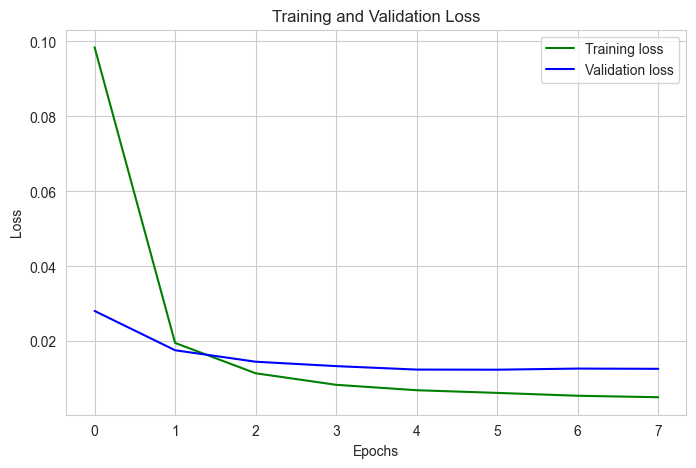

62/62 [==============================] - 1s 13ms/step
Classification report for #1 model without LR optimization (exact match): 



d:\anconda\envs\wkj\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: PAD seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
d:\anconda\envs\wkj\lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          AD       0.00      0.00      0.00         0
        GENE       0.93      0.77      0.84      2145
   PHENOTYPE       0.71      0.81      0.76       789

   micro avg       0.85      0.78      0.81      2934
   macro avg       0.54      0.53      0.53      2934
weighted avg       0.87      0.78      0.82      2934

F1-score: 0.815
Word            Pred : (True)
Although       :O               (O)
the            :O               (O)
homologs       :O               (O)
can            :O               (O)
[UNK]          :O               (O)
[UNK]          :O               (O)
from           :O               (O)
each           :O               (O)
other          :O               (O)
at             :O               (O)
the            :O               (O)
end            :O               (O)
of             :O               (O)
meiosis        :B-PHENOTYPE     (B-PHENOTYPE)
I              :O               (O)
,              :O      

In [13]:
plt.rcParams["figure.figsize"] = [8,5]
loss_train = history.history["loss"]
loss_val = history.history['val_loss']
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='Validation loss')
plt.xticks(np.arange(0, len(epochs)))
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, -1)
y_hat, y_true = ignoring_padding(y_pred, y_test)
from nervaluate import Evaluator
golden_tags = ["protein", "cell_type", "cell_line", "DNA", "RNA"]
evaluator = Evaluator(y_true, y_hat, tags = golden_tags, loader="list")
results, results_by_tag = evaluator.evaluate()
import pandas as pd
res = pd.DataFrame.from_dict(results)
res
from seqeval.metrics import classification_report
print('\033[1m' + "Classification report for #1 model without LR optimization (exact match): ")
print('\033[0m')
print(classification_report(y_true, y_hat))
results_by_tag
print("F1-score: {:0.3}".format(f1_score(y_true, y_hat,  mode="strict")))
# COMPARE RESULTS
i = 18
# From tensor to array
X_test1 = tf.make_tensor_proto(X_test)
X_test1 = tf.make_ndarray(X_test1)
# Compare results
print("{:15} {:5}: ({})".format("Word", "Pred", "True"))
print("="*45)
for w, true, pred in zip(X_test1[i], y_true[i], y_hat[i]):
  print("{:15}:{:15} ({})".format(idx2word[w], pred, true))
